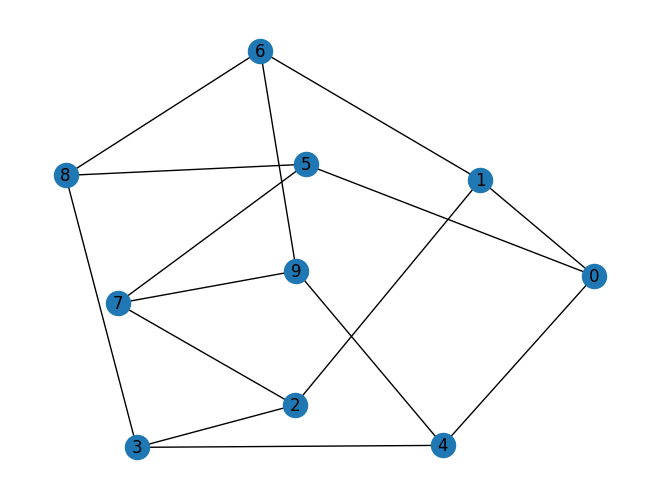

In [11]:
from find_cubic_local_mincut import *
import matplotlib.pyplot as plt

N, T = 10, 3

if G := generate_high_girth_cubic_graph(N, T, max_tries=1_000_000):
    nx.draw(G, with_labels=True)
else:
    print("No graph found")

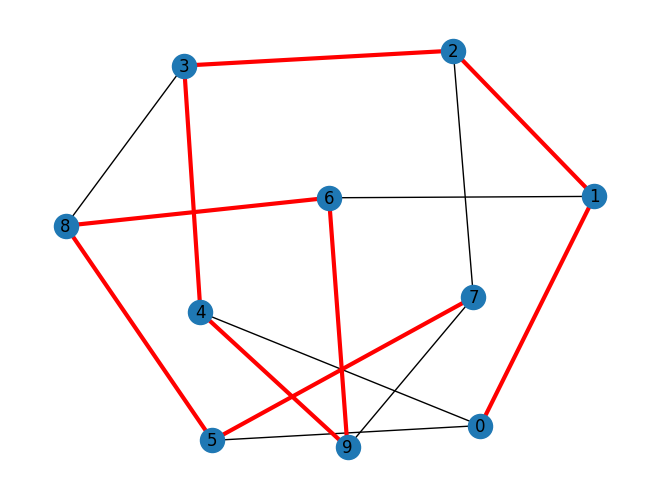

In [12]:
from cat_state_generation import *

p = next(find_all_hamiltonian_paths(G))
pos = nx.drawing.layout.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True)
nx.draw_networkx_edges(
    G, pos=pos,
    edgelist=list(zip(p, p[1:])),
    edge_color='red', width=3.0
)

T = 5
N = 12
{0: array([-0.90895064,  0.21880023]), 1: array([0.03979692, 0.73057712]), 2: array([0.88288601, 0.45771285]), 3: array([ 0.69888994, -0.43691008]), 4: array([-0.37285319, -0.10413915]), 5: array([-0.48220673, -0.55230129]), 6: array([ 0.13822381, -0.1646066 ]), 7: array([0.21498954, 0.31963024]), 8: array([ 0.21415961, -1.        ]), 9: array([-0.42493527,  0.53123669])}


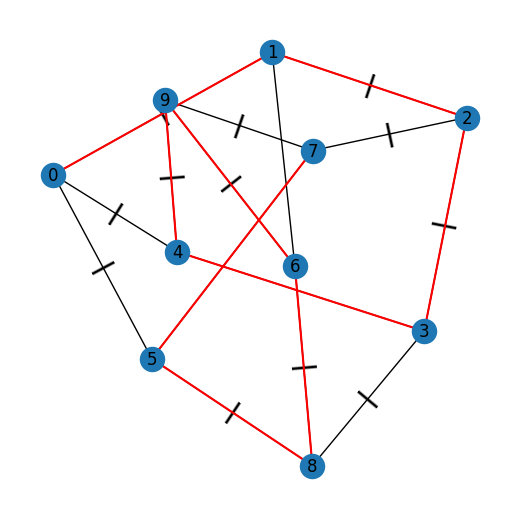

In [14]:
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
from pysat.formula import WCNF
from pysat.examples.rc2 import RC2

# --- 3. Run and Compare ---

# Create a graph
marker = GraphMarker(G, ham_path=list(zip(p, p[1:])), max_marks=30)

print("T = 5")
res1 = marker.find_solution(T = 4)
print(f"N = {sum(v for k, v in res1.items())}")
visualize_cat_state_base(G, list(zip(p, p[1:])), res1)

# print("T = 5")
# res2 = marker.solve_problem_2()
# print(f"N = {sum(v for k, v in res2.items())}")
# visualize_markings(G, res2)
#
# print("T = 6")
# res3 = marker.solve_problem_3()
# print(f"N = {sum(v for k, v in res3.items())}")
# visualize_markings(G, res3)

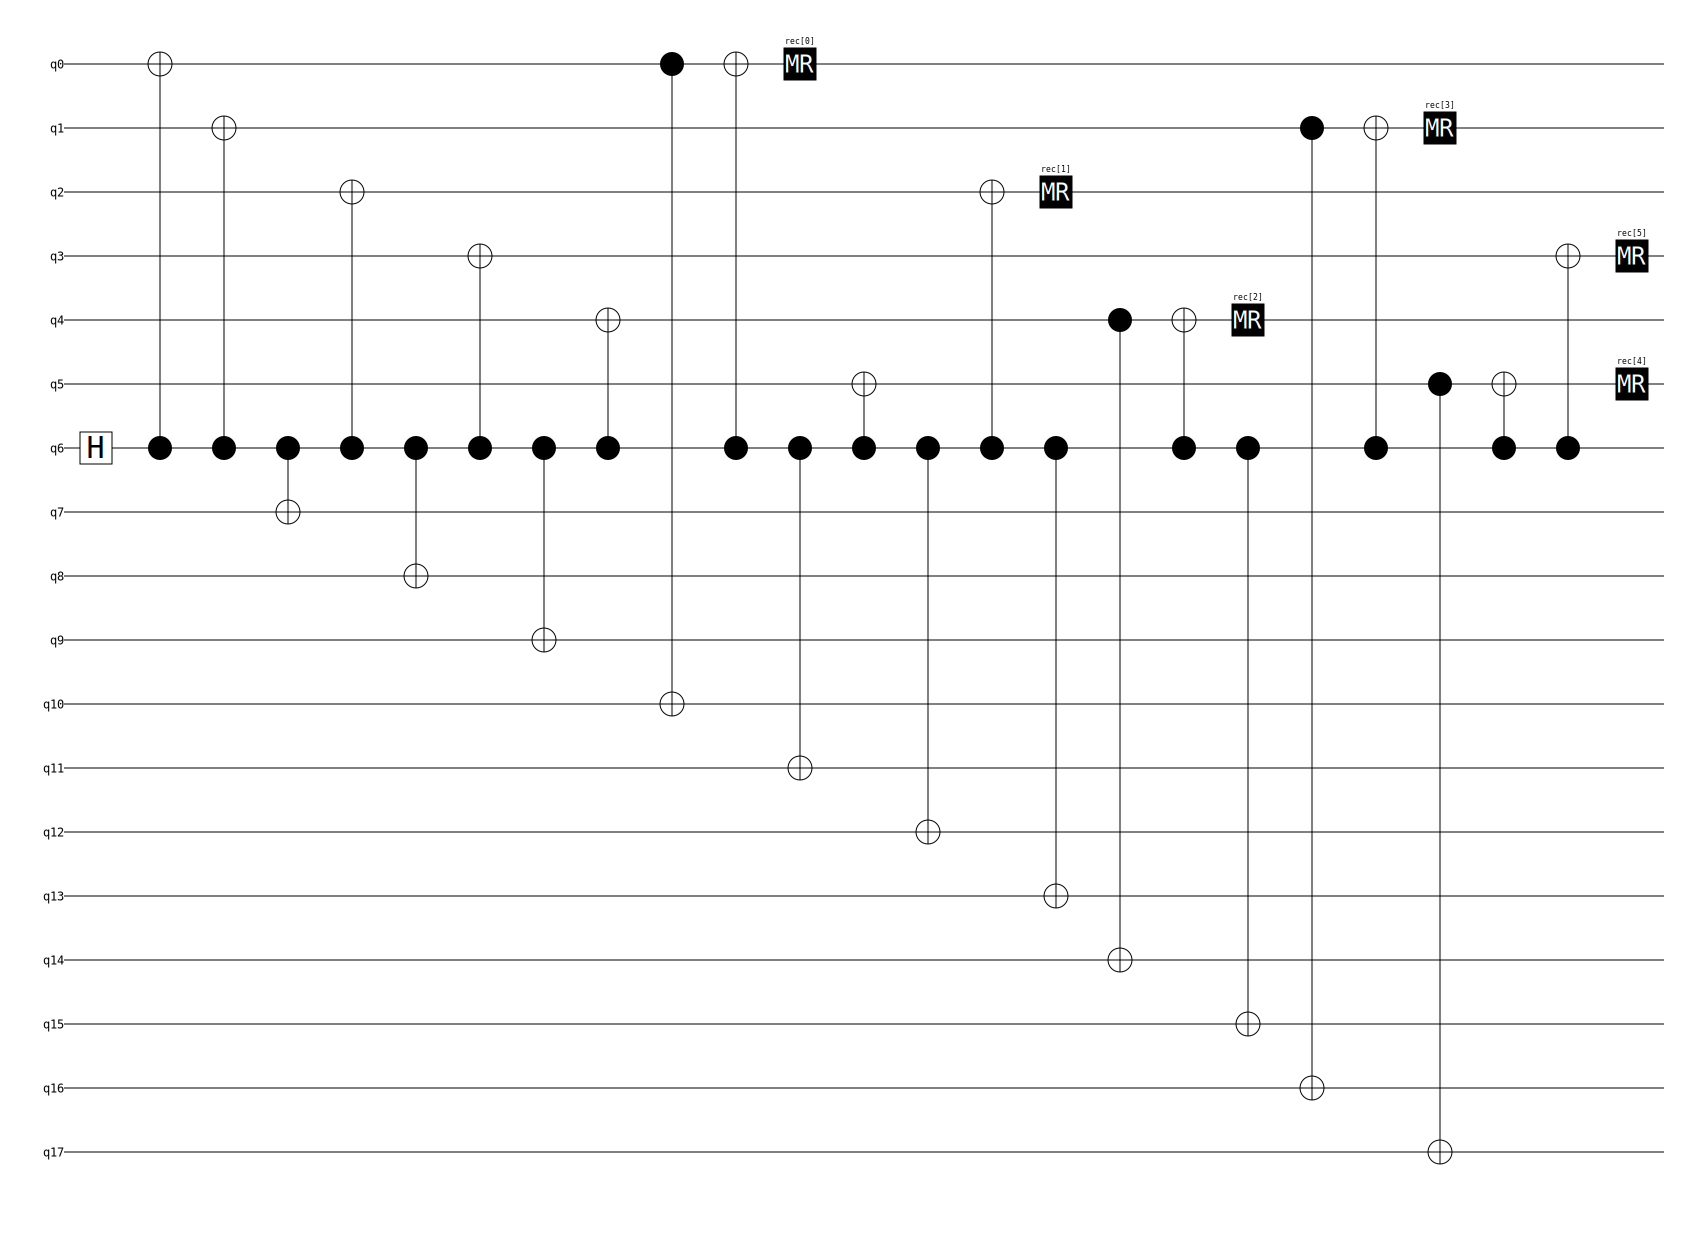

In [4]:
circ = cat_state_FT(12, 4)
circ.diagram('timeline-svg')

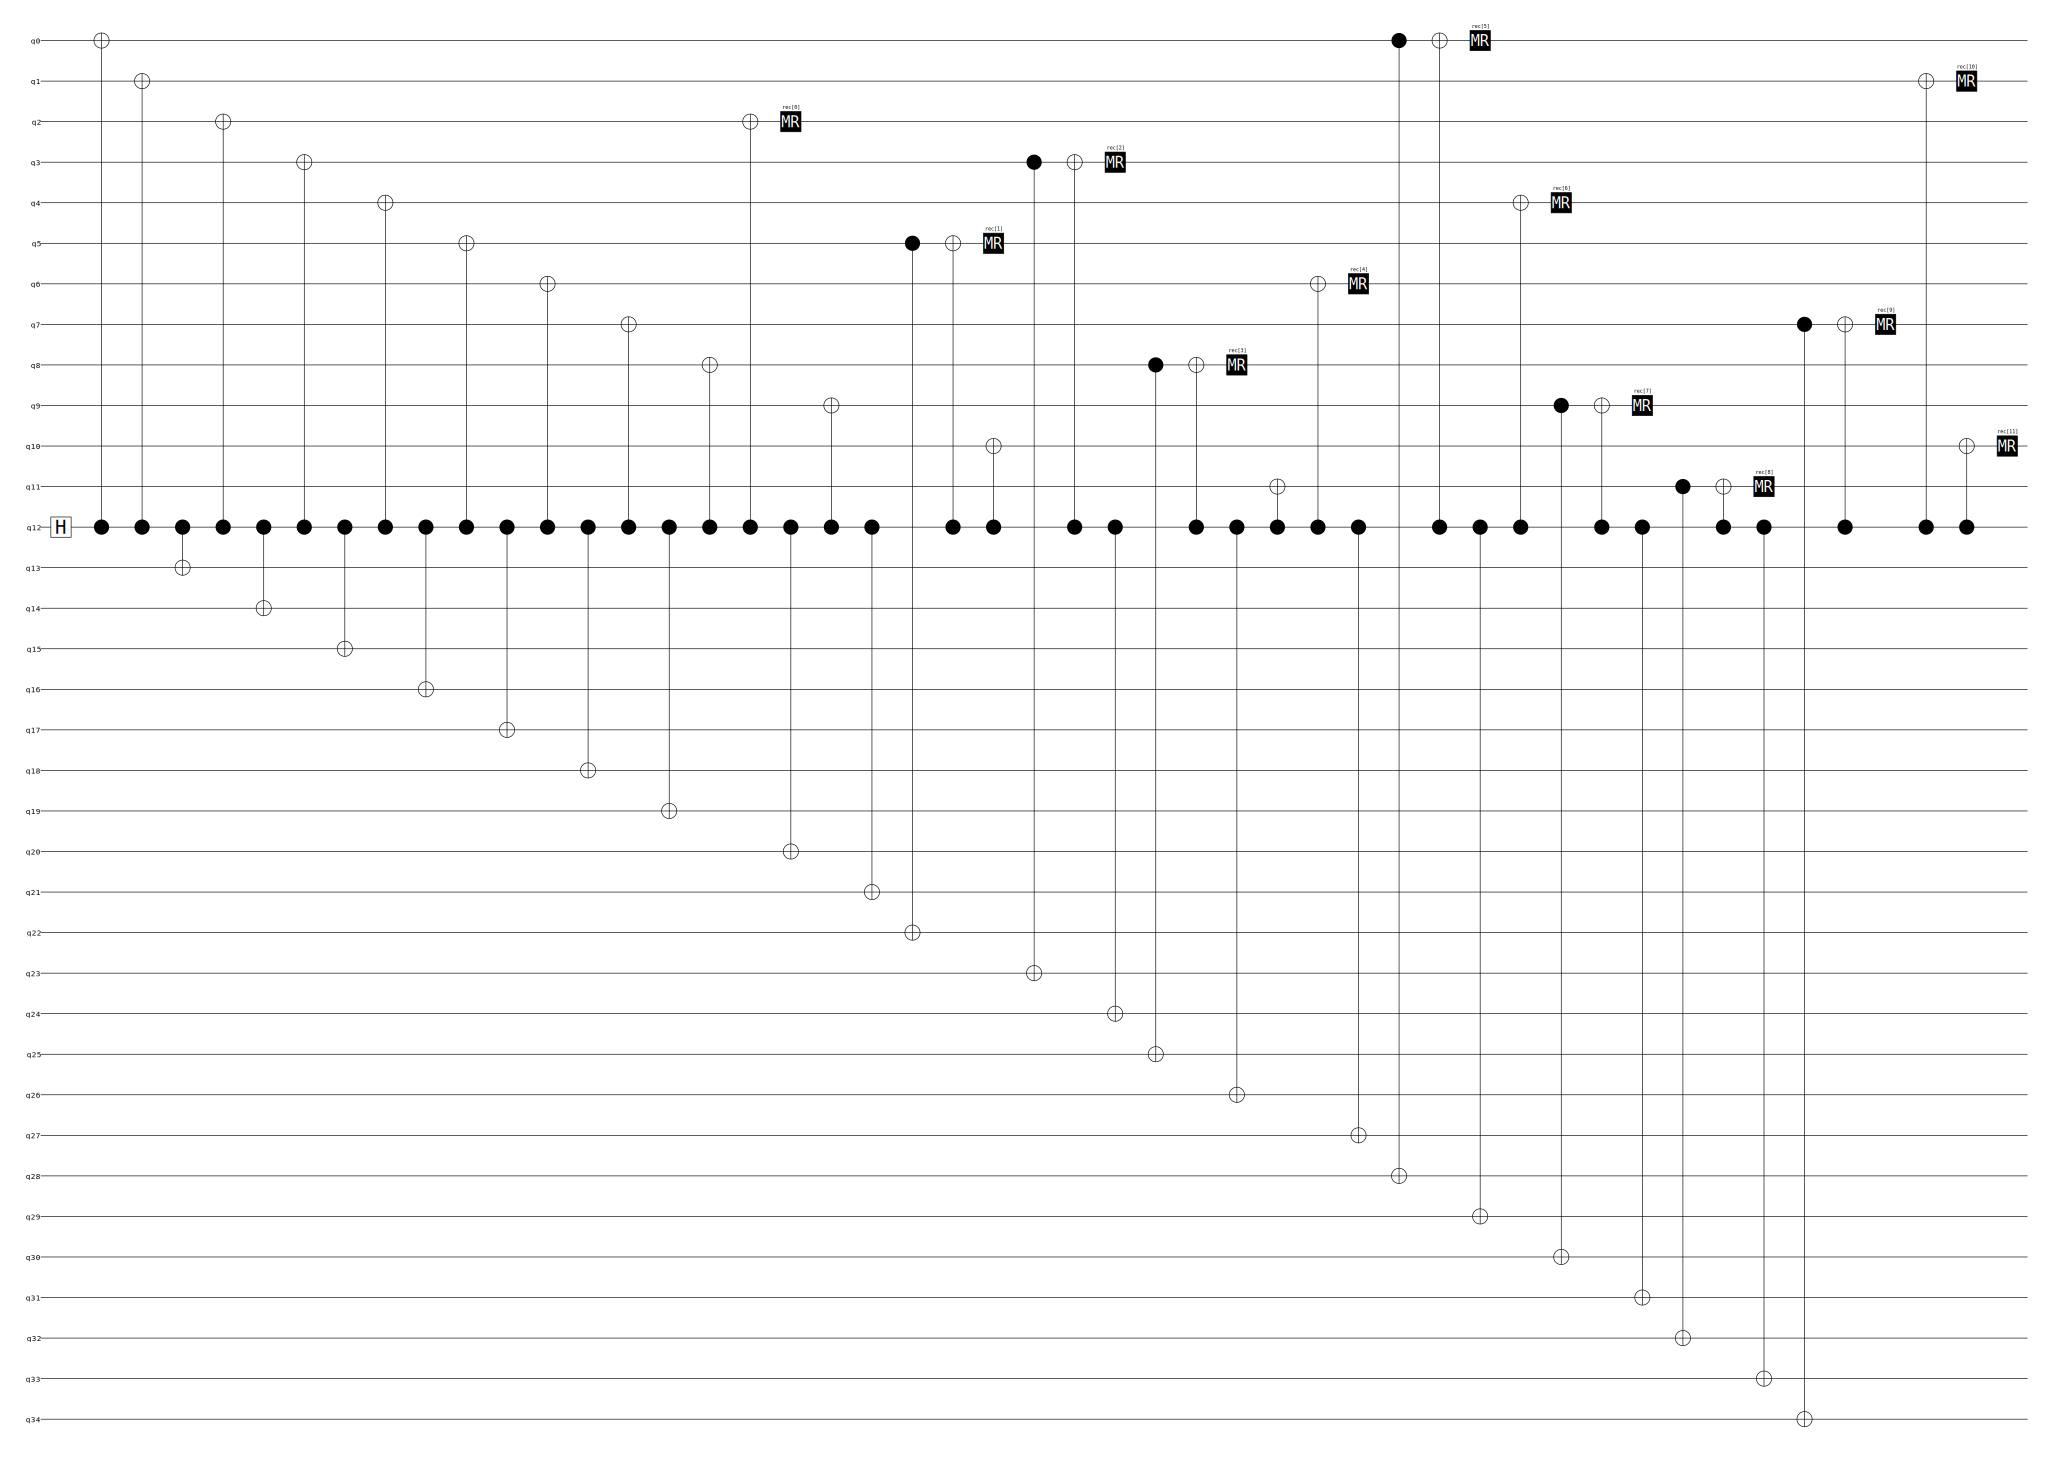

In [5]:
import stim


def sorted_pair(v1, v2):
    return (v1, v2) if v1 < v2 else (v2, v1)


circ = extract_circuit(G, list(zip(p, p[1:])), res1)
circ.diagram('timeline-svg')

In [6]:
circ.to_qasm(open_qasm_version=3)

'OPENQASM 3.0;\ninclude "stdgates.inc";\ndef mr(qubit q0) -> bit { bit b; measure q0 -> b; reset q0; return b; }\n\nqreg q[35];\ncreg rec[12];\n\nh q[12];\ncx q[12], q[0];\ncx q[12], q[1];\ncx q[12], q[13];\ncx q[12], q[2];\ncx q[12], q[14];\ncx q[12], q[3];\ncx q[12], q[15];\ncx q[12], q[4];\ncx q[12], q[16];\ncx q[12], q[5];\ncx q[12], q[17];\ncx q[12], q[6];\ncx q[12], q[18];\ncx q[12], q[7];\ncx q[12], q[19];\ncx q[12], q[8];\ncx q[12], q[2];\nrec[0] = mr(q[2]);\ncx q[12], q[20];\ncx q[12], q[9];\ncx q[12], q[21];\ncx q[5], q[22];\ncx q[12], q[5];\nrec[1] = mr(q[5]);\ncx q[12], q[10];\ncx q[3], q[23];\ncx q[12], q[3];\nrec[2] = mr(q[3]);\ncx q[12], q[24];\ncx q[8], q[25];\ncx q[12], q[8];\nrec[3] = mr(q[8]);\ncx q[12], q[26];\ncx q[12], q[11];\ncx q[12], q[6];\nrec[4] = mr(q[6]);\ncx q[12], q[27];\ncx q[0], q[28];\ncx q[12], q[0];\nrec[5] = mr(q[0]);\ncx q[12], q[29];\ncx q[12], q[4];\nrec[6] = mr(q[4]);\ncx q[9], q[30];\ncx q[12], q[9];\nrec[7] = mr(q[9]);\ncx q[12], q[31];\ncx q[

In [ ]:
from cat_state_generation import cat_state_FT

cat_state_FT(48, 4).diagram('timeline-svg')

In [1]:
from cat_state_generation import *
from find_cubic_local_mincut import *

N, T = 12, 4
#
# def visualize_cat_state_base(G, ham_path, markings):
#     plt.figure(figsize=(5, 5))
#     pos = nx.circular_layout(G) # Kamada-Kawai usually looks best for regular graphs
#     nx.draw(G, pos, with_labels=True)
#     nx.draw_networkx_edge_labels(G, pos, edge_labels={e: "  |  " * num_marks for e, num_marks in markings.items()},
#                                  font_size=18, font_weight='bold', bbox=dict(alpha=0))
#     nx.draw_networkx_edges(
#         G, pos=pos,
#         edgelist=ham_path,
#         edge_color='red', width=1.5
#     )
#     plt.show()

for i, G in enumerate(generate_all_cubic_graph_with_local_cuts(N, 0), 1):
    plt.figure(i, figsize=(4,4))
    p = list(find_all_hamiltonian_paths(G))
    p = p[0]
    ham_path = list(zip(p, p[1:]))
    # plt.title(f"{nx.girth(G) = }; {nx.algebraic_connectivity(G) = }")
    # visualize_cat_state_base(G, [], {})
    # plt.show()
    # marker = GraphMarker(G, ham_path, 12)
    # sol = marker.find_necessary_solution(T=5)
    # n_actual = (sum(sol.values()))
    # if n_actual == N:
    #     visualize_cat_state_base(G, [], {})
    #     break
# plt.show()
    # nx.draw(G, pos=pos, with_labels=True)

/var/folders/nk/pr_kp7mj53jfmybw8sl71x6m0000gp/T/ipykernel_26797/2326835664.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i, figsize=(4,4))


<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [2]:
has_small_nonlocal_cut(G, 2)

True

In [3]:
for b in nx.cycle_basis(Gs[1]):
    print(len(b), b)

NameError: name 'Gs' is not defined

In [4]:
i

85

In [5]:
45**6

8303765625

In [6]:
nx.is_regular_expander(G)
# nx.girth(nx.heawood_graph())

True

In [7]:
nx.spectrum.adjacency_spectrum(nx.heawood_graph())

array([ 3.        +0.j, -3.        +0.j,  1.41421356+0.j, -1.41421356+0.j,
       -1.41421356+0.j, -1.41421356+0.j,  1.41421356+0.j,  1.41421356+0.j,
       -1.41421356+0.j,  1.41421356+0.j, -1.41421356+0.j,  1.41421356+0.j,
        1.41421356+0.j, -1.41421356+0.j])

48
21
21


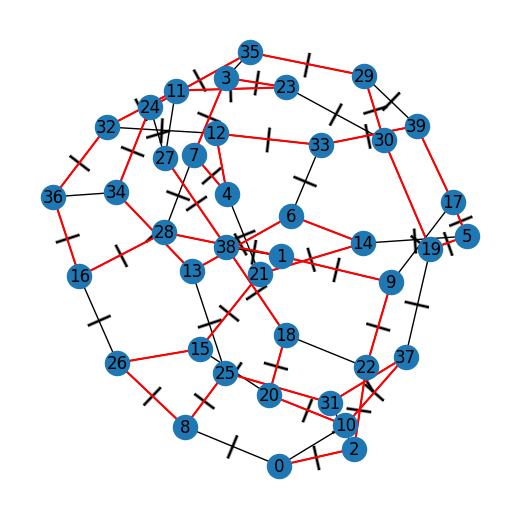

In [12]:
import networkx as nx

n, t = 48, 4

edges = [(0, 2), (0, 8), (0, 10), (1, 9), (1, 28), (1, 38), (2, 22), (2, 31), (3, 7), (3, 23), (3, 35), (4, 12), (4, 21), (4, 7), (5, 19), (5, 17), (5, 14), (6, 33), (6, 14), (6, 13), (7, 28), (8, 25), (8, 26), (9, 22), (9, 17), (10, 20), (10, 37), (11, 23), (11, 27), (11, 32), (12, 32), (12, 33), (13, 25), (13, 34), (14, 21), (15, 20), (15, 26), (15, 21), (16, 28), (16, 36), (16, 26), (17, 39), (18, 20), (18, 22), (18, 38), (19, 30), (19, 37), (23, 30), (24, 27), (24, 35), (24, 34), (25, 31), (27, 38), (29, 30), (29, 39), (29, 35), (31, 37), (32, 36), (33, 39), (34, 36)]
G = nx.Graph(edges)
paths_gen = find_all_hamiltonian_paths(G)
next(paths_gen)
next(paths_gen)
next(paths_gen)
next(paths_gen)
p = next(paths_gen)
ham_path = list(zip(p, p[1:]))
marker = GraphMarker(G, ham_path=ham_path, max_marks=48)
marks = marker.find_solution(T=4)

print(sum(marks.values()))
print(minimum_number_of_flags(n, t))
circ = extract_circuit(G, ham_path, marks)
print(circ.num_qubits - n)


visualize_cat_state_base(G, ham_path, marks)
# circ.diagram('timeline-svg')

In [19]:
GraphMarker(G, ham_path=ham_path, max_marks=n).find_solution(T=t)

{(0, 1): 0,
 (0, 17): 0,
 (0, 5): 0,
 (1, 2): 1,
 (1, 8): 1,
 (17, 12): 1,
 (17, 16): 1,
 (5, 4): 1,
 (5, 6): 1,
 (2, 3): 1,
 (2, 13): 1,
 (8, 7): 1,
 (8, 9): 1,
 (3, 4): 0,
 (3, 10): 1,
 (13, 12): 1,
 (13, 14): 0,
 (4, 15): 0,
 (10, 9): 0,
 (10, 11): 0,
 (15, 14): 1,
 (15, 16): 1,
 (6, 7): 1,
 (6, 11): 1,
 (7, 14): 0,
 (11, 12): 1,
 (9, 16): 0}

In [1]:
4 * 4 / 48

0.3333333333333333